In [1]:
import pandas as pd
import numpy as np
from numpy import loadtxt
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import KMeansSMOTE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("credit_card_data.csv")

In [3]:
data.head(2)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1


In [4]:
data.rename(columns = {"default payment next month": "Default"}, inplace = True)
data.drop("ID", axis = 1, inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  30000 non-null  int64
 1   SEX        30000 non-null  int64
 2   EDUCATION  30000 non-null  int64
 3   MARRIAGE   30000 non-null  int64
 4   AGE        30000 non-null  int64
 5   PAY_0      30000 non-null  int64
 6   PAY_2      30000 non-null  int64
 7   PAY_3      30000 non-null  int64
 8   PAY_4      30000 non-null  int64
 9   PAY_5      30000 non-null  int64
 10  PAY_6      30000 non-null  int64
 11  BILL_AMT1  30000 non-null  int64
 12  BILL_AMT2  30000 non-null  int64
 13  BILL_AMT3  30000 non-null  int64
 14  BILL_AMT4  30000 non-null  int64
 15  BILL_AMT5  30000 non-null  int64
 16  BILL_AMT6  30000 non-null  int64
 17  PAY_AMT1   30000 non-null  int64
 18  PAY_AMT2   30000 non-null  int64
 19  PAY_AMT3   30000 non-null  int64
 20  PAY_AMT4   30000 non-null  int64
 21  PAY_AMT5   3

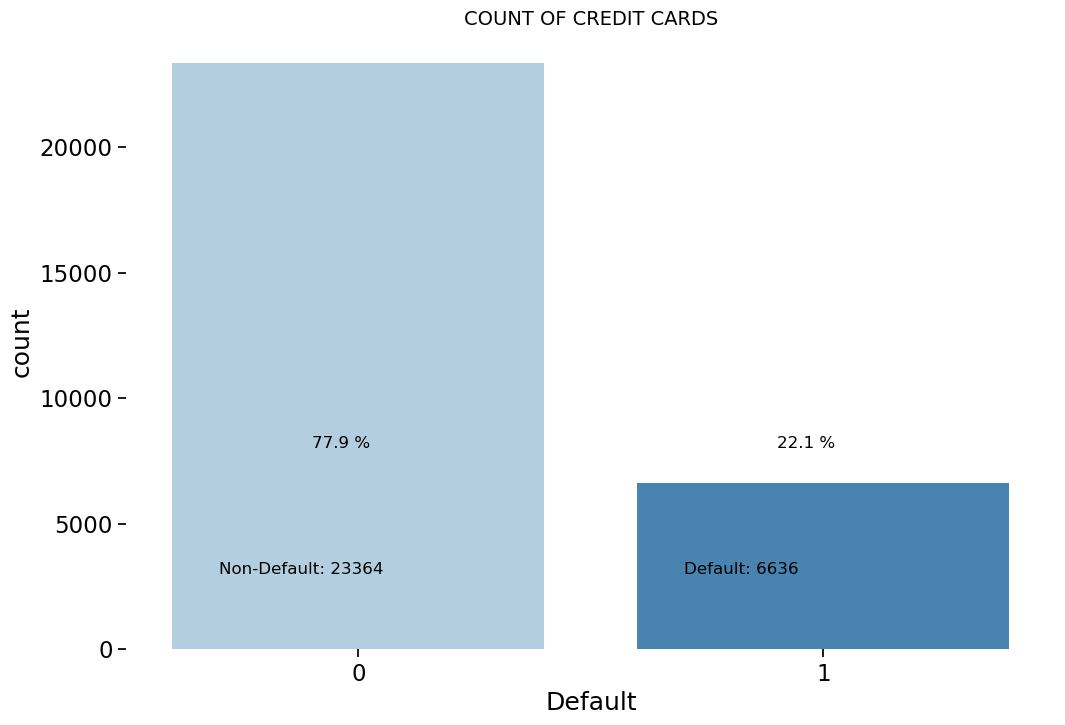

In [5]:
defaults = data["Default"].value_counts().iloc[1]
no_defaults = len(data) - defaults

default_percentage = round(defaults/len(data) * 100, 1)
no_default_percentage = round(no_defaults/len(data) * 100, 1)

plt.figure(figsize = (12, 8))
sns.set_context('notebook', font_scale = 1.5)
sns.countplot(x = 'Default', data = data, palette = 'Blues')
plt.annotate('Non-Default: {}'.format(no_defaults), xy = (-0.3, 15000), xytext = (-0.3, 3000), size = 12)
plt.annotate('Default: {}'.format(defaults), xy = (0.7, 15000), xytext = (0.7, 3000), size = 12)
plt.annotate(str(no_default_percentage) + " %", xy = (-0.3, 15000), xytext = (-0.1, 8000), size = 12)
plt.annotate(str(default_percentage) + " %", xy = (0.7, 15000), xytext = (0.9, 8000), size = 12)
plt.title('COUNT OF CREDIT CARDS', size = 14)
plt.box(False);

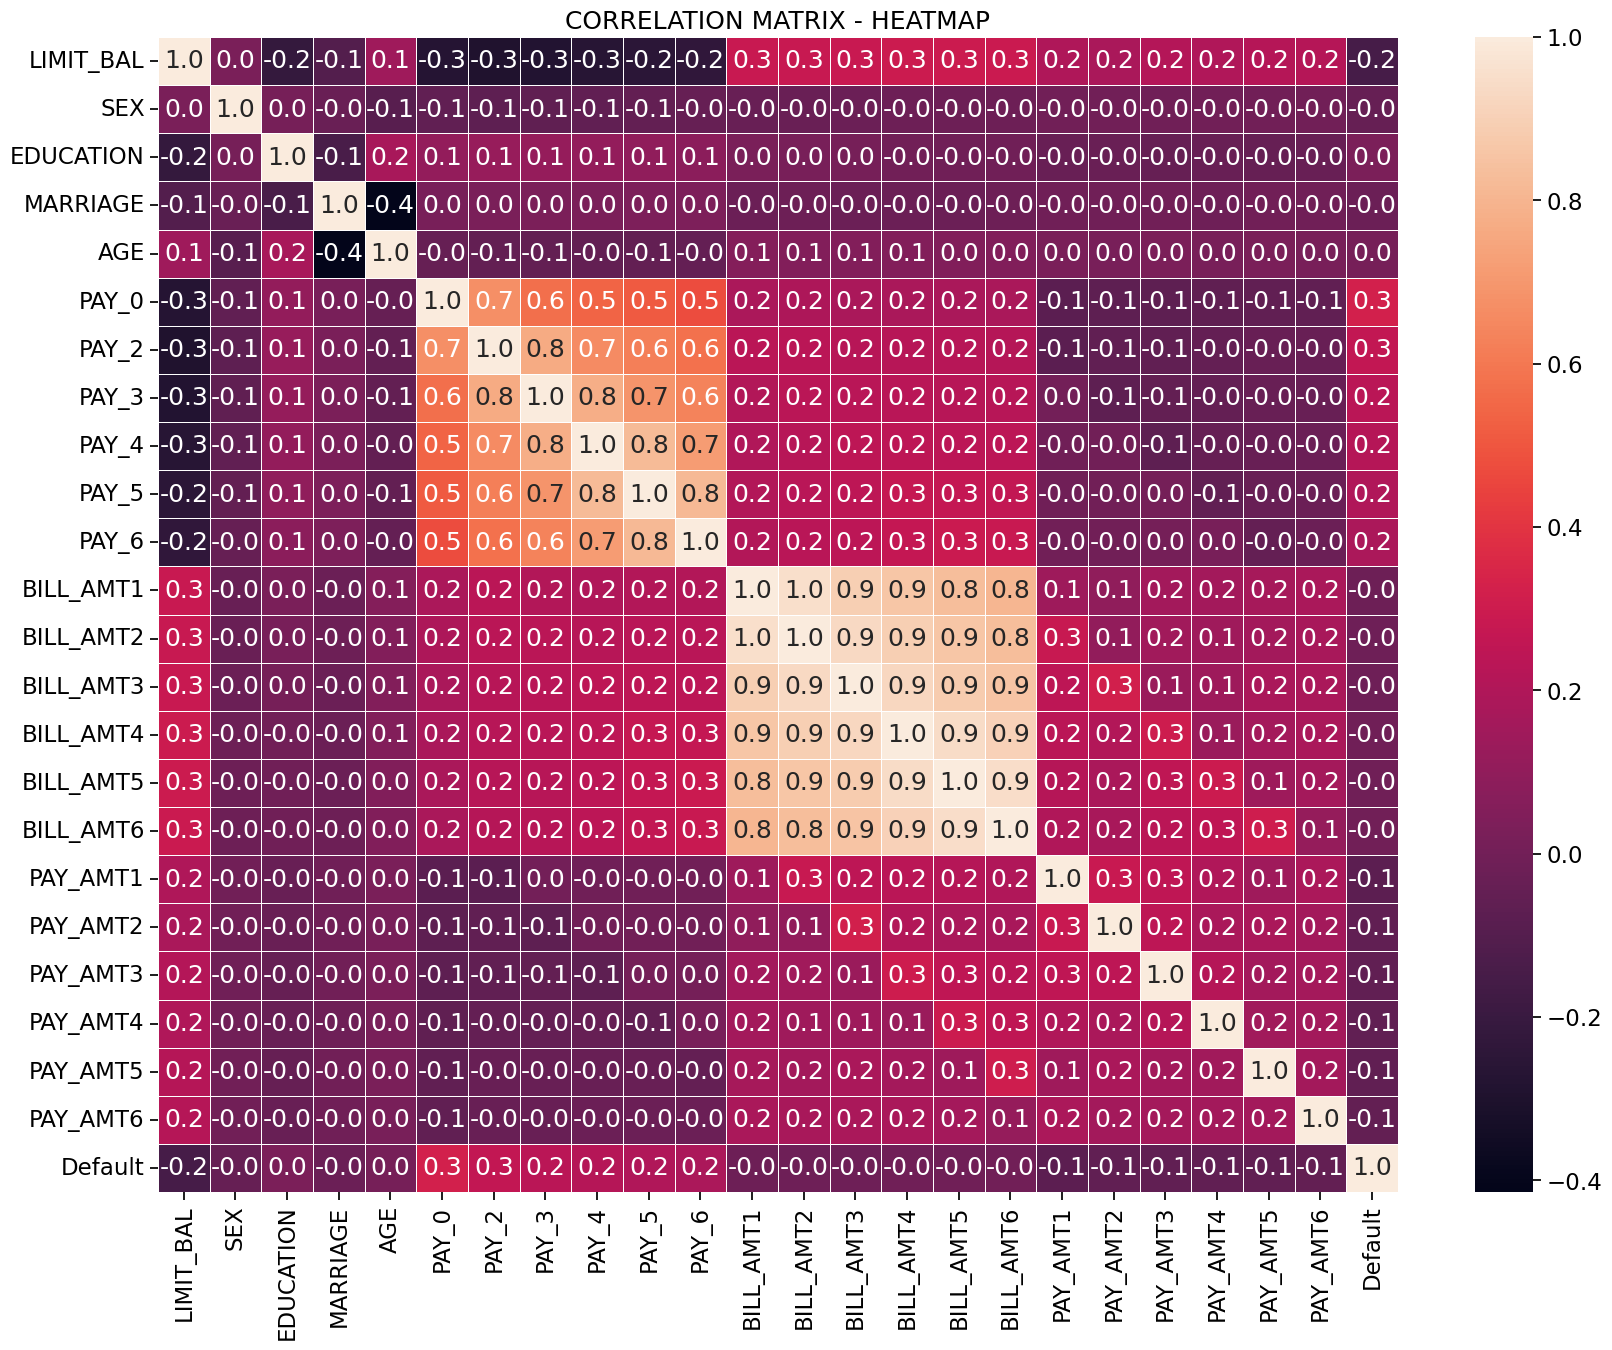

In [6]:
corr = data.corr()
f, ax = plt.subplots(figsize = (20, 15))
sns.heatmap(corr, cbar = True, annot = True, fmt = ".001f", xticklabels = True, yticklabels = True, linewidth = .5, ax = ax)
plt.title('CORRELATION MATRIX - HEATMAP', size = 18);

In [7]:
dataset = data.astype({
    'LIMIT_BAL': 'float64',
    'SEX': 'category',
    'EDUCATION': 'category',
    'MARRIAGE': 'category',
    'AGE': 'float32',
    'PAY_0': 'category',
    'PAY_2': 'category',
    'PAY_3': 'category',
    'PAY_4': 'category',
    'PAY_5': 'category',
    'PAY_6': 'category',
    'BILL_AMT1': 'float64',
    'BILL_AMT2': 'float64',
    'BILL_AMT3': 'float64',
    'BILL_AMT4': 'float64',
    'BILL_AMT5': 'float64',
    'BILL_AMT6': 'float64',
    'PAY_AMT1': 'float64',
    'PAY_AMT2': 'float64',
    'PAY_AMT3': 'float64',
    'PAY_AMT4': 'float64',
    'PAY_AMT5': 'float64',
    'PAY_AMT6': 'float64',
    'Default': 'category',
}, copy = False)

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   LIMIT_BAL  30000 non-null  float64 
 1   SEX        30000 non-null  category
 2   EDUCATION  30000 non-null  category
 3   MARRIAGE   30000 non-null  category
 4   AGE        30000 non-null  float32 
 5   PAY_0      30000 non-null  category
 6   PAY_2      30000 non-null  category
 7   PAY_3      30000 non-null  category
 8   PAY_4      30000 non-null  category
 9   PAY_5      30000 non-null  category
 10  PAY_6      30000 non-null  category
 11  BILL_AMT1  30000 non-null  float64 
 12  BILL_AMT2  30000 non-null  float64 
 13  BILL_AMT3  30000 non-null  float64 
 14  BILL_AMT4  30000 non-null  float64 
 15  BILL_AMT5  30000 non-null  float64 
 16  BILL_AMT6  30000 non-null  float64 
 17  PAY_AMT1   30000 non-null  float64 
 18  PAY_AMT2   30000 non-null  float64 
 19  PAY_AMT3   30000 non-null

In [9]:
dataset['MARRIAGE'].unique()

[1, 2, 3, 0]
Categories (4, int64): [0, 1, 2, 3]

In [10]:
dataset['MARRIAGE'] = np.where(dataset['MARRIAGE'] == 0, 3, dataset['MARRIAGE'])
dataset['MARRIAGE'].unique()

array([1, 2, 3], dtype=int64)

In [11]:
dataset['EDUCATION'].unique()

[2, 1, 3, 5, 4, 6, 0]
Categories (7, int64): [0, 1, 2, 3, 4, 5, 6]

In [12]:
dataset['EDUCATION'] = np.where(dataset['EDUCATION'] == 5, 4, dataset['EDUCATION'])
dataset['EDUCATION'] = np.where(dataset['EDUCATION'] == 6, 4, dataset['EDUCATION'])
dataset['EDUCATION'] = np.where(dataset['EDUCATION'] == 0, 4, dataset['EDUCATION'])
dataset['EDUCATION'].unique()

array([2, 1, 3, 4], dtype=int64)

In [13]:
default_dataset = dataset[dataset['Default'] == 1]
no_default_dataset = dataset[dataset['Default'] == 0]

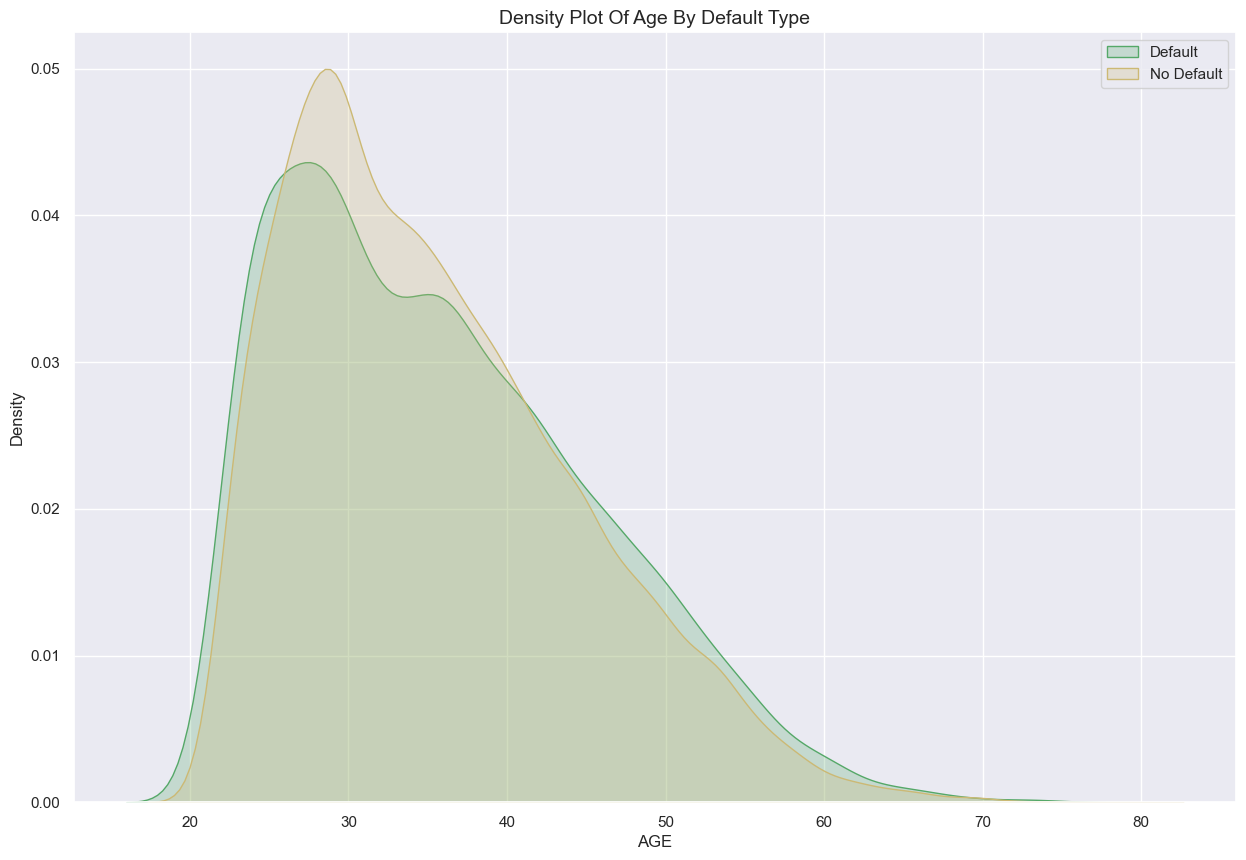

In [14]:
plt.figure(figsize = (15, 10))
sns.set(style = "darkgrid")
fig = sns.kdeplot(default_dataset['AGE'], shade = True, color = 'g')
fig = sns.kdeplot(no_default_dataset['AGE'], shade = True, color = 'y')
plt.title('Density Plot Of Age By Default Type', size = 14)
plt.legend(labels = ['Default', 'No Default'])
plt.ticklabel_format(useOffset = False, style = 'plain')
plt.show()

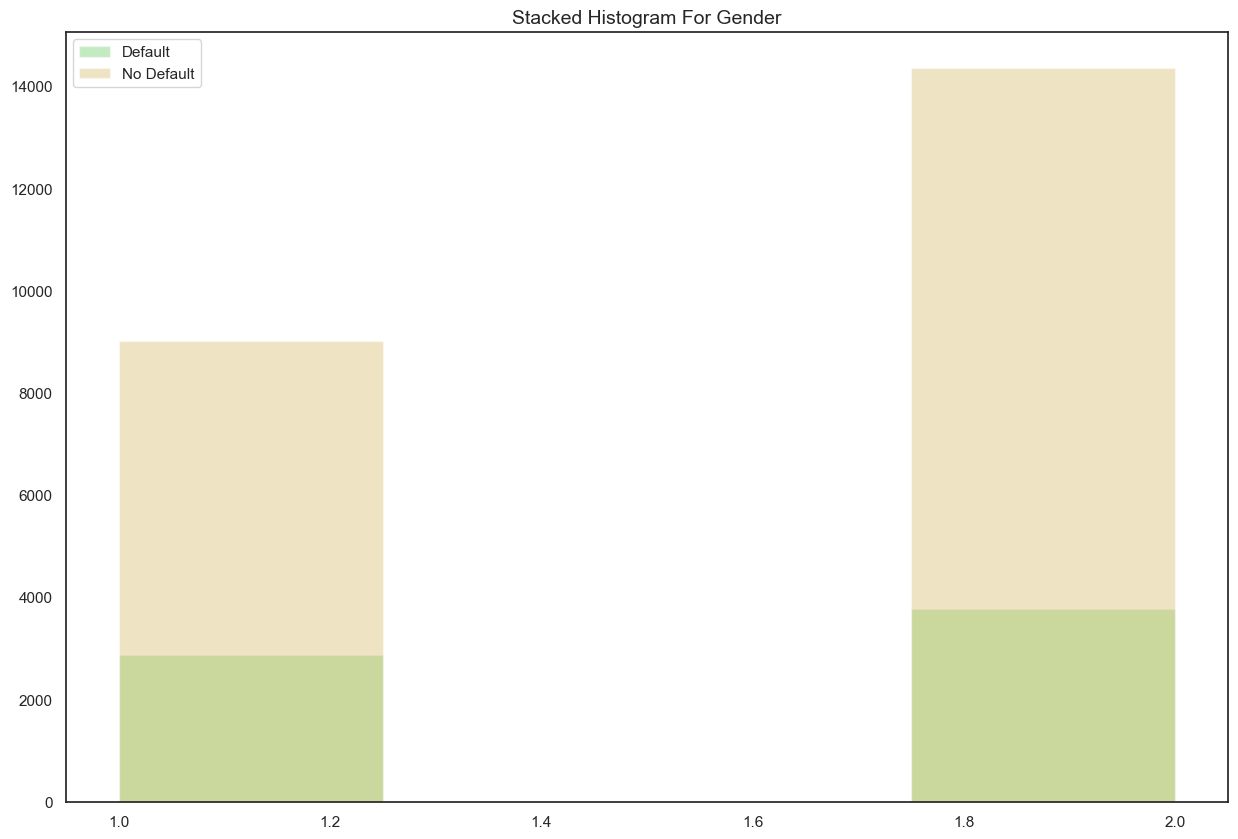

In [15]:
plt.figure(figsize = (15, 10))
sns.set(style = 'white', palette = 'muted', color_codes = True)

sns.distplot(x = default_dataset['SEX'], kde = False, bins = 4, color = 'g')
sns.distplot(x = no_default_dataset['SEX'], kde = False, bins = 4, color = 'y')

plt.title('Stacked Histogram For Gender', size = 14)
plt.legend(labels = ['Default', 'No Default'])
plt.show()

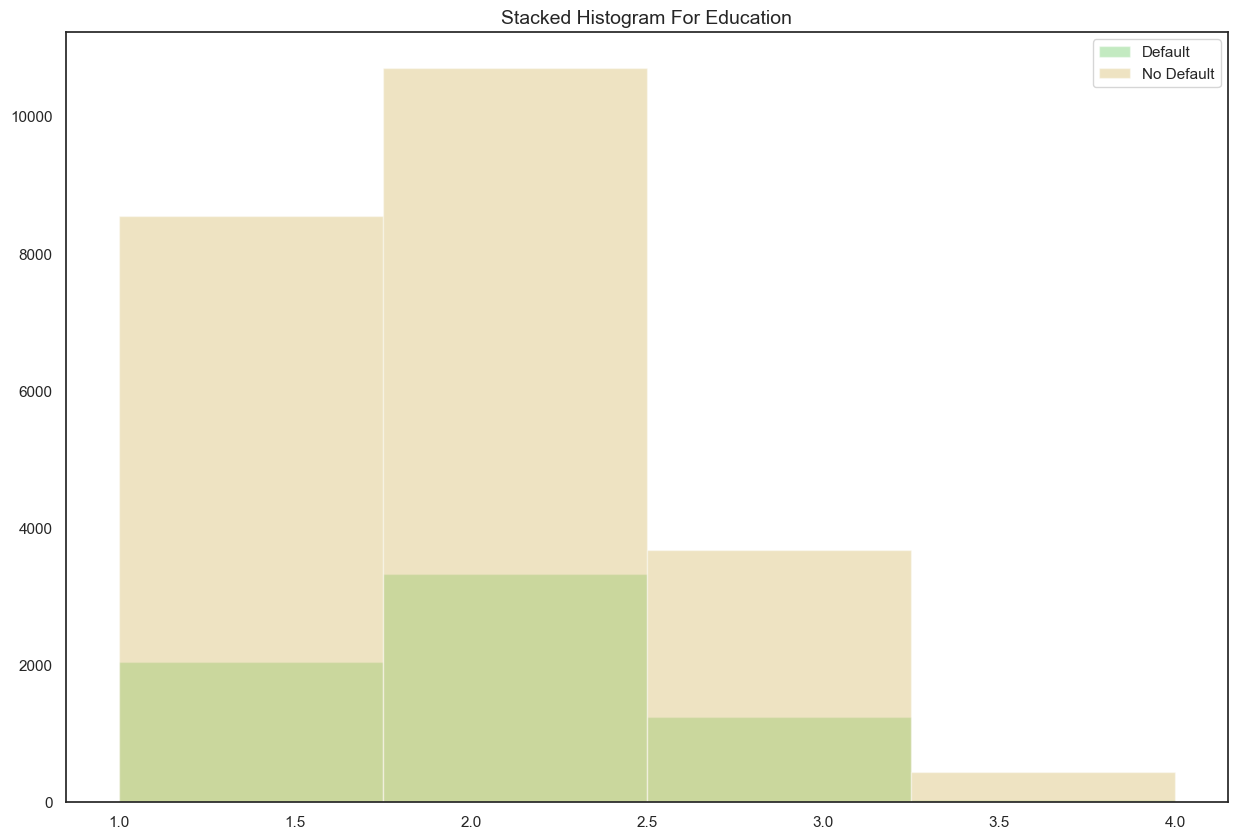

In [16]:
plt.figure(figsize = (15, 10))
sns.set(style = 'white', palette = 'muted', color_codes = True)

sns.distplot(x = default_dataset['EDUCATION'], kde = False, bins = 4, color = 'g')
sns.distplot(x = no_default_dataset['EDUCATION'], kde = False, bins = 4, color = 'y')

plt.title('Stacked Histogram For Education', size = 14)
plt.legend(labels = ['Default', 'No Default'])
plt.show()

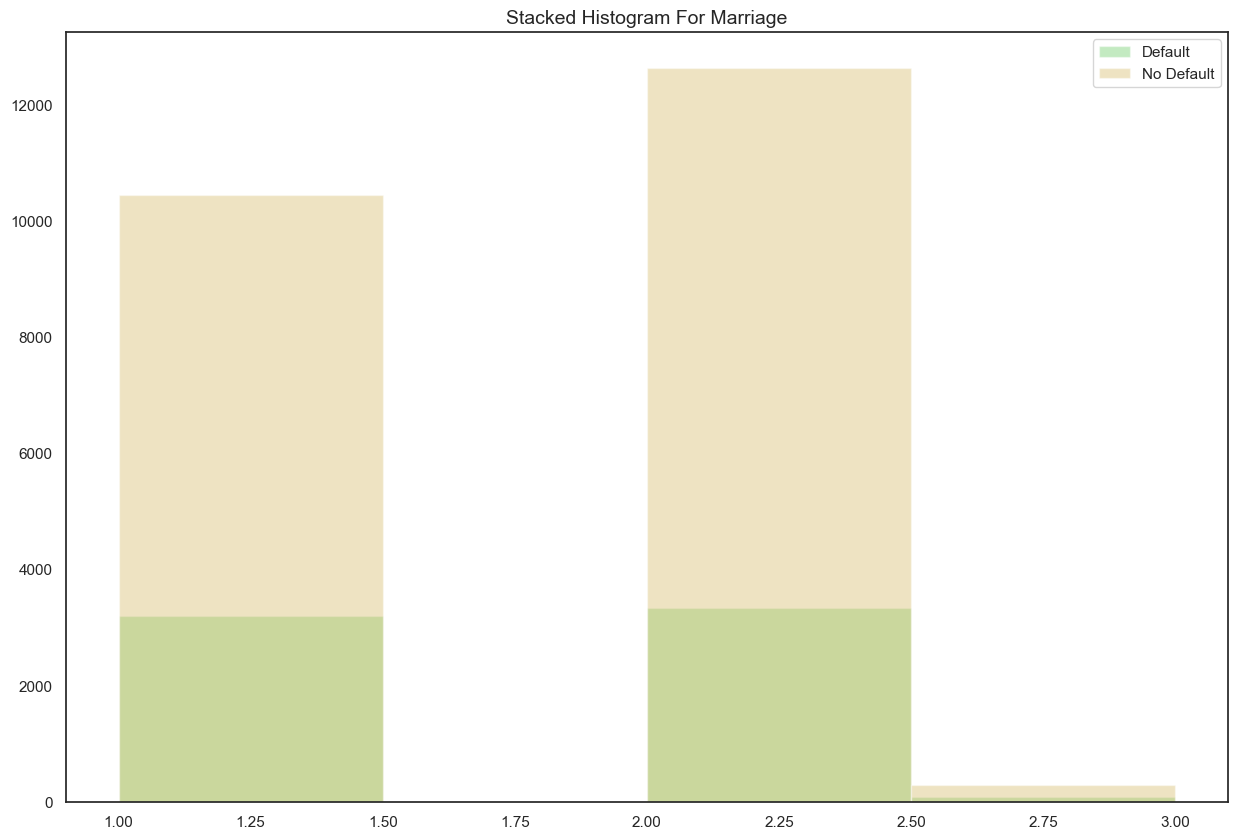

In [17]:
plt.figure(figsize = (15, 10))
sns.set(style = 'white', palette = 'muted', color_codes = True)

sns.distplot(x = default_dataset['MARRIAGE'], kde = False, bins = 4, color = 'g')
sns.distplot(x = no_default_dataset['MARRIAGE'], kde = False, bins = 4, color = 'y')

plt.title('Stacked Histogram For Marriage', size = 14)
plt.legend(labels = ['Default', 'No Default'])
plt.show()

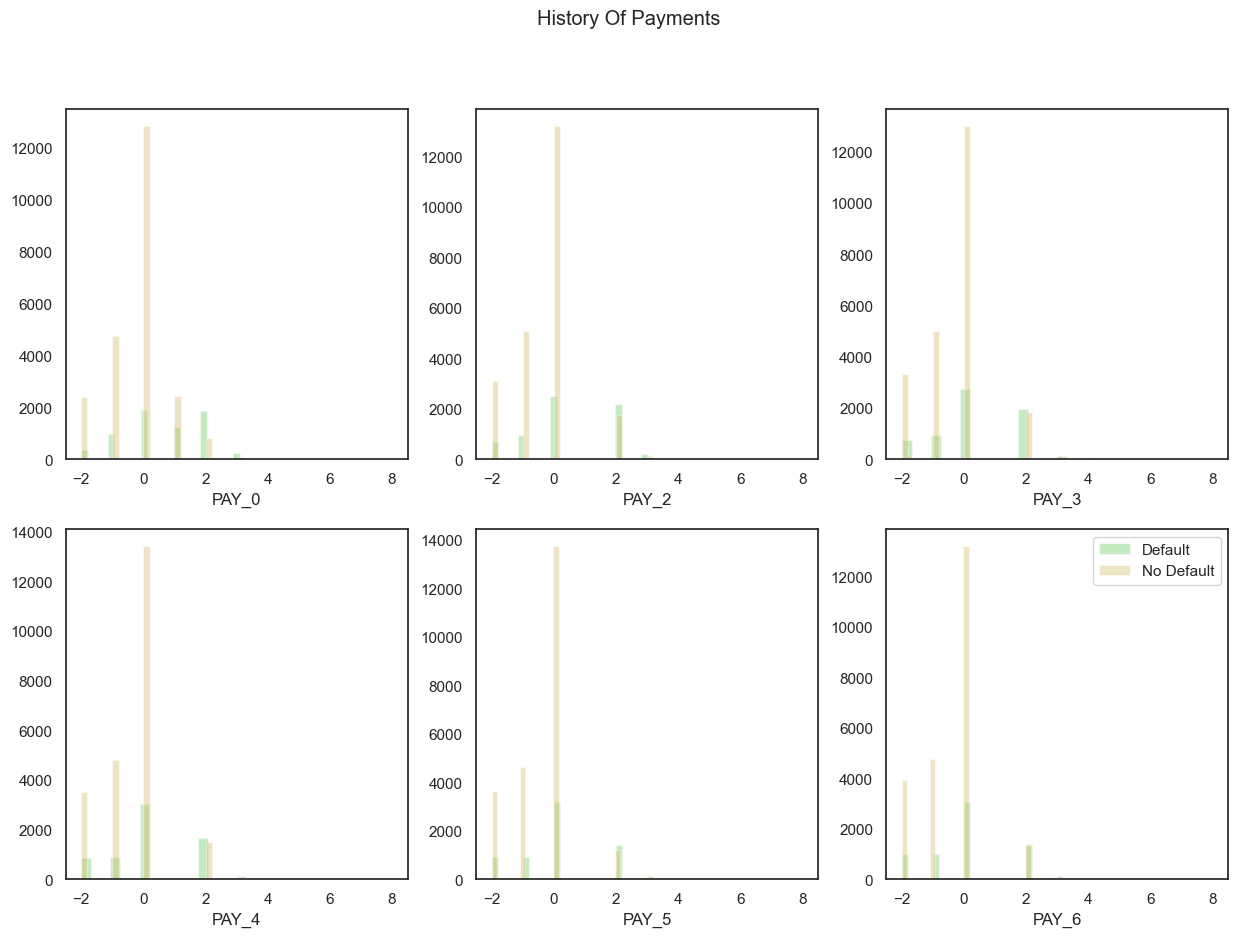

In [18]:
fig, axes = plt.subplots(2, 3, figsize = (15, 10))
fig.suptitle('History Of Payments')

sns.distplot(default_dataset['PAY_0'], kde = False, color = 'g', ax = axes[0, 0])
sns.distplot(no_default_dataset['PAY_0'], kde = False, color = 'y', ax = axes[0, 0])

sns.distplot(default_dataset['PAY_2'], kde = False, color = 'g', ax = axes[0, 1])
sns.distplot(no_default_dataset['PAY_2'], kde = False, color = 'y', ax = axes[0, 1])

sns.distplot(default_dataset['PAY_3'], kde = False, color = 'g', ax = axes[0, 2])
sns.distplot(no_default_dataset['PAY_3'], kde = False, color = 'y', ax = axes[0, 2])

sns.distplot(default_dataset['PAY_4'], kde = False, color = 'g', ax = axes[1, 0])
sns.distplot(no_default_dataset['PAY_4'], kde = False, color = 'y', ax = axes[1, 0])

sns.distplot(default_dataset['PAY_5'], kde = False, color = 'g', ax = axes[1, 1])
sns.distplot(no_default_dataset['PAY_5'], kde = False, color = 'y', ax = axes[1, 1])

sns.distplot(default_dataset['PAY_6'], kde = False, color = 'g', ax = axes[1, 2])
sns.distplot(no_default_dataset['PAY_6'], kde = False, color = 'y', ax = axes[1, 2])

plt.legend(labels = ['Default', 'No Default'])
plt.show()

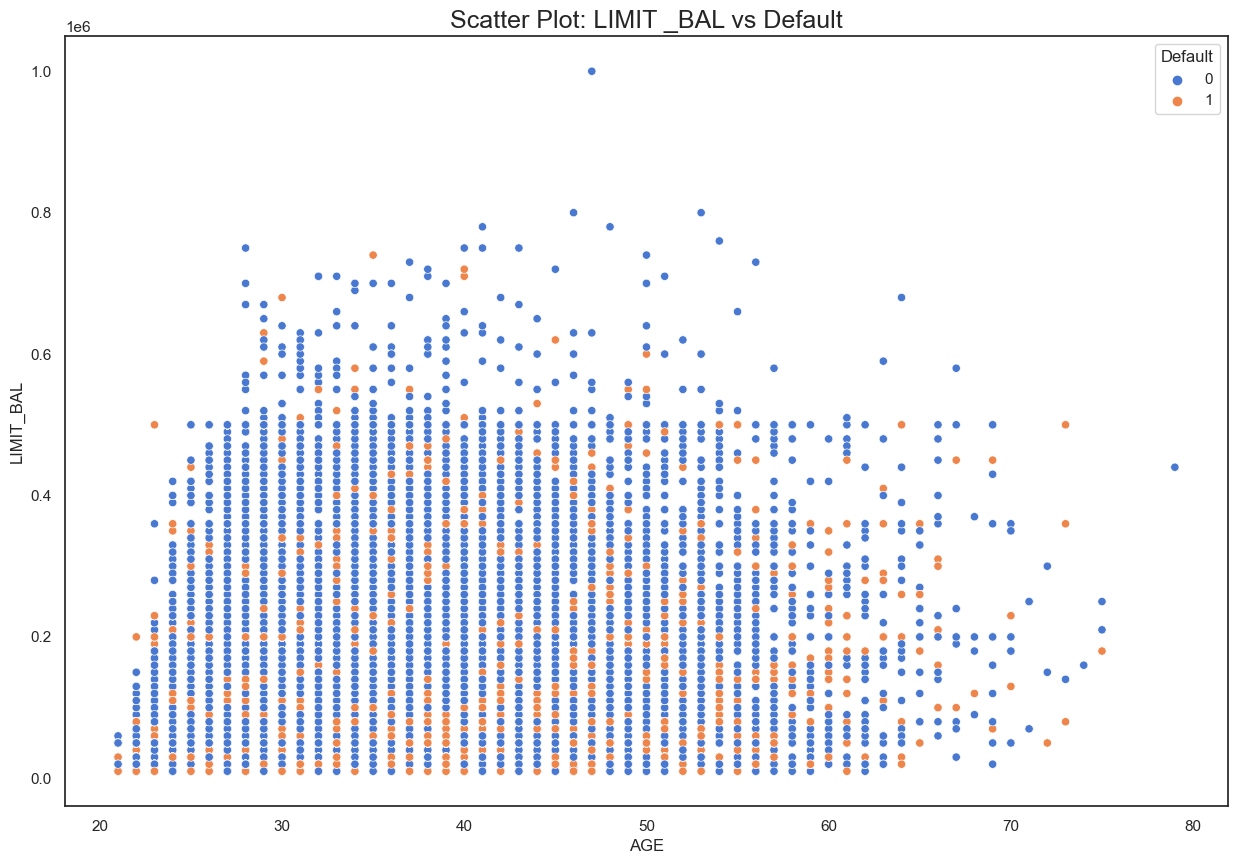

In [19]:
plt.figure(figsize = (15, 10))

sns.scatterplot(data = dataset, x = "AGE", y = "LIMIT_BAL", hue = "Default")
plt.title('Scatter Plot: LIMIT _BAL vs Default', size = 18)
plt.show()

In [20]:
y = dataset.Default
features = dataset.drop('Default', axis = 1, inplace = False)

In [21]:
%env OMP_NUM_THREADS = 4

sm = KMeansSMOTE(random_state = 42, k_neighbors = 100, kmeans_estimator = 300)
resampled_features, resampled_y = sm.fit_resample(features, y)

env: OMP_NUM_THREADS=4


In [22]:
resampled_dataset = pd.concat([resampled_features, resampled_y], axis = 1)

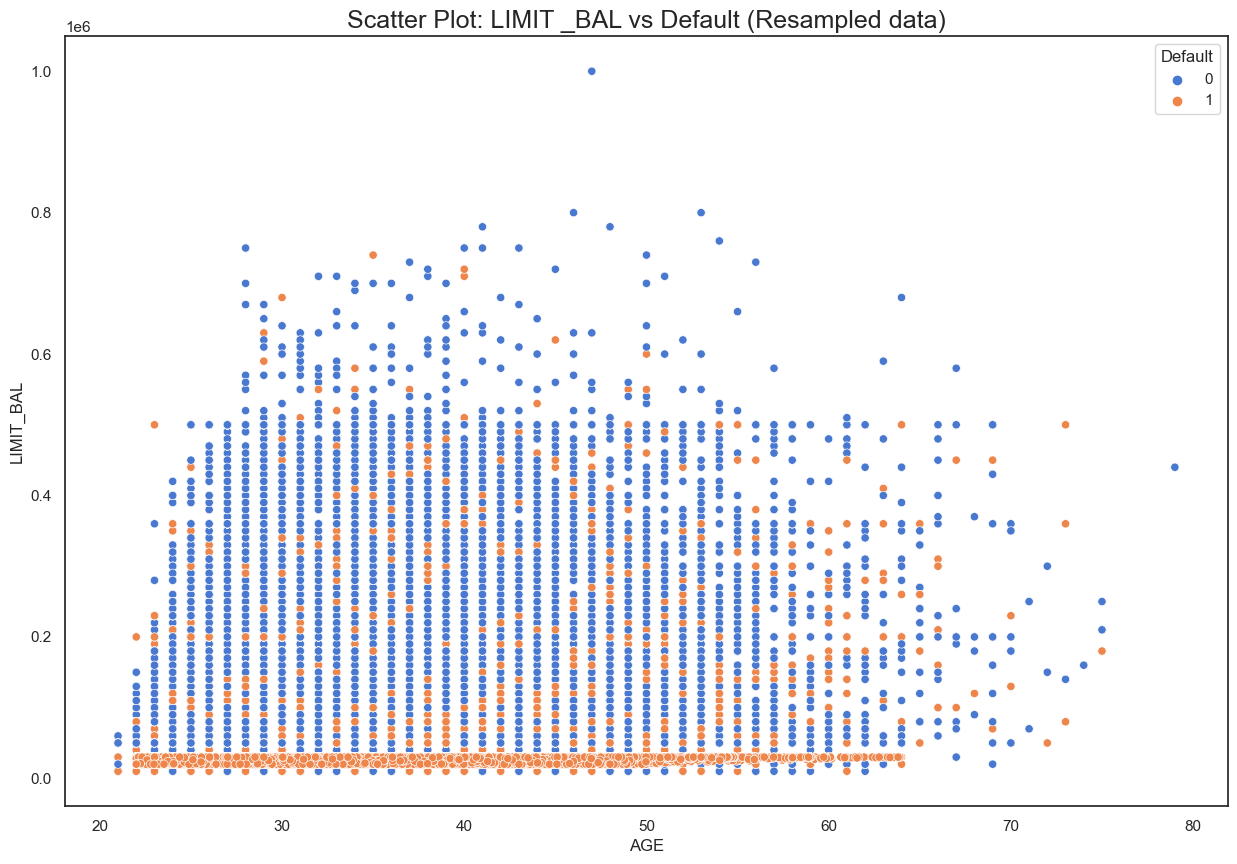

In [23]:
plt.figure(figsize = (15, 10))

sns.scatterplot(data = resampled_dataset, x = "AGE", y = "LIMIT_BAL", hue = "Default")
plt.title('Scatter Plot: LIMIT _BAL vs Default (Resampled data)', size = 18)
plt.show()

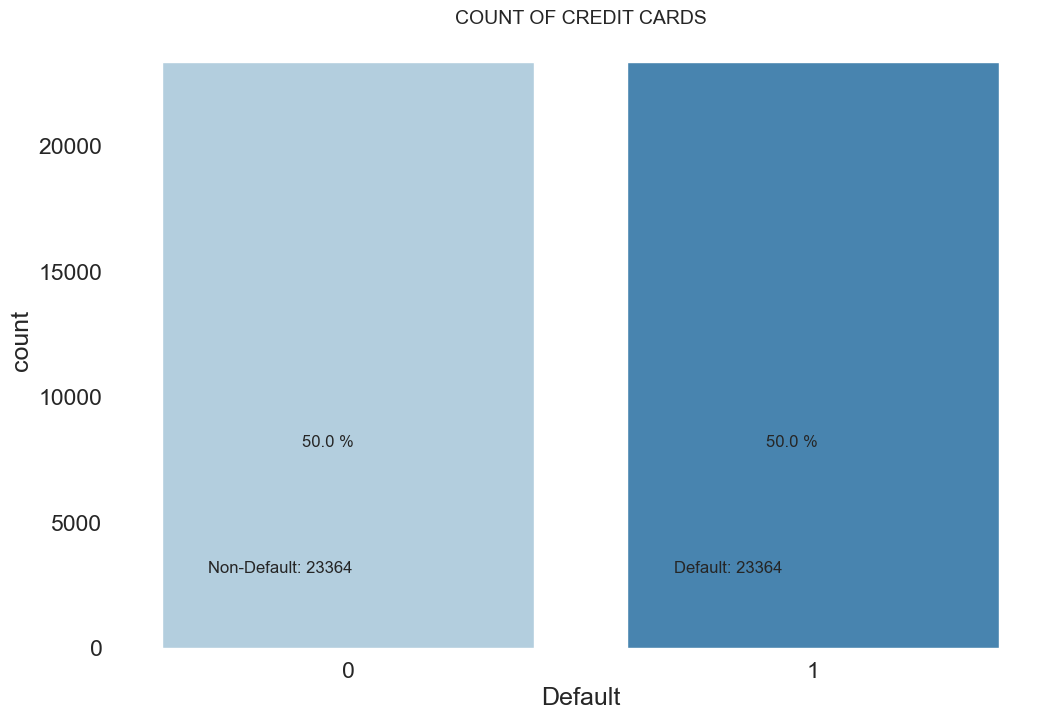

In [24]:
resampled_defaults = resampled_dataset["Default"].value_counts().iloc[1]
resampled_no_defaults = len(resampled_dataset) - resampled_defaults

resampled_defaults_percentage = round(resampled_defaults/len(resampled_dataset) * 100, 1)
resampled_no_defaults_percentage = round(resampled_no_defaults/len(resampled_dataset) * 100, 1)

plt.figure(figsize = (12, 8))
sns.set_context('notebook', font_scale = 1.5)
sns.countplot(x = 'Default', data = resampled_dataset, palette = 'Blues')
plt.annotate('Non-Default: {}'.format(resampled_no_defaults), xy = (-0.3, 15000), xytext = (-0.3, 3000), size = 12)
plt.annotate('Default: {}'.format(resampled_defaults), xy = (0.7, 15000), xytext = (0.7, 3000), size = 12)
plt.annotate(str(resampled_no_defaults_percentage) + " %", xy = (-0.3, 15000), xytext = (-0.1, 8000), size = 12)
plt.annotate(str(resampled_defaults_percentage) + " %", xy = (0.7, 15000), xytext = (0.9, 8000), size = 12)
plt.title('COUNT OF CREDIT CARDS', size = 14)
plt.box(False);

In [25]:
def onehot_encode(df, column_dict):
    df = df.copy()
    for column, prefix in column_dict.items():
        dummies = pd.get_dummies(df[column], prefix = prefix)
        df = pd.concat([df, dummies], axis = 1)
        df = df.drop(column, axis = 1)
    return df

In [26]:
resampled_df = onehot_encode(
    resampled_dataset,
    {
        'EDUCATION': 'EDU',
        'MARRIAGE': 'MAR',
        'SEX': 'SX',
        'PAY_0': 'PAY0',
        'PAY_2': 'PAY2',
        'PAY_3': 'PAY3',
        'PAY_4': 'PAY4',
        'PAY_5': 'PAY5',
        'PAY_6': 'PAY6'
    }
)

In [27]:
resampled_df.columns

Index(['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'Default', 'EDU_1', 'EDU_2',
       'EDU_3', 'EDU_4', 'MAR_1', 'MAR_2', 'MAR_3', 'SX_1', 'SX_2', 'PAY0_-2',
       'PAY0_-1', 'PAY0_0', 'PAY0_1', 'PAY0_2', 'PAY0_3', 'PAY0_4', 'PAY0_5',
       'PAY0_6', 'PAY0_7', 'PAY0_8', 'PAY2_-2', 'PAY2_-1', 'PAY2_0', 'PAY2_1',
       'PAY2_2', 'PAY2_3', 'PAY2_4', 'PAY2_5', 'PAY2_6', 'PAY2_7', 'PAY2_8',
       'PAY3_-2', 'PAY3_-1', 'PAY3_0', 'PAY3_1', 'PAY3_2', 'PAY3_3', 'PAY3_4',
       'PAY3_5', 'PAY3_6', 'PAY3_7', 'PAY3_8', 'PAY4_-2', 'PAY4_-1', 'PAY4_0',
       'PAY4_1', 'PAY4_2', 'PAY4_3', 'PAY4_4', 'PAY4_5', 'PAY4_6', 'PAY4_7',
       'PAY4_8', 'PAY5_-2', 'PAY5_-1', 'PAY5_0', 'PAY5_2', 'PAY5_3', 'PAY5_4',
       'PAY5_5', 'PAY5_6', 'PAY5_7', 'PAY5_8', 'PAY6_-2', 'PAY6_-1', 'PAY6_0',
       'PAY6_2', 'PAY6_3', 'PAY6_4', 'PAY6_5', 'PAY6_6', 'PAY6_7', 'PAY6_8

In [28]:
resampled_df = resampled_df.sample(frac = 1)

In [29]:
resampled_y = resampled_df['Default'].copy()
resampled_X = resampled_df.drop('Default', axis = 1).copy()

In [30]:
scaler = StandardScaler()
scaled_X = pd.DataFrame(scaler.fit_transform(resampled_X), columns = resampled_X.columns)

In [31]:
scaled_X.head(2)

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,PAY6_-2,PAY6_-1,PAY6_0,PAY6_2,PAY6_3,PAY6_4,PAY6_5,PAY6_6,PAY6_7,PAY6_8
0,0.509135,0.553116,-0.601800,-0.614370,-0.615461,-0.499351,-0.500266,-0.627285,-0.288884,-0.217995,...,-0.342071,-0.374221,-0.851495,2.521424,-0.073635,-0.032399,-0.016682,-0.020169,-0.031391,-0.006542
1,-0.134945,0.331608,0.942817,1.009705,1.069164,1.215341,1.312166,1.360847,0.022516,0.019121,...,-0.342071,-0.374221,1.174405,-0.396601,-0.073635,-0.032399,-0.016682,-0.020169,-0.031391,-0.006542


In [32]:
X = scaled_X
y = resampled_y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [33]:
def summarize_classification(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred, normalize = True)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    fscore = 2 * (precision * recall) / (precision + recall)
    
    print('Accuracy: %.2f%s' %(accuracy * 100, '%'))
    print('Precision: %.2f%s' %(precision * 100, '%'))
    print('Recall: %.2f%s' %(recall * 100, '%'))
    print('F-Score: %.2f%s' %(fscore * 100, '%'))
    print('')
    
def print_score(model, fn_name):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    print('Classification:', fn_name)
    print('------------------------')
    print('**** Training Data ****')
    train_summary = summarize_classification(y_train, y_pred_train)
    print('**** Test Data ****')
    test_summary = summarize_classification(y_test, y_pred)
    

In [34]:
lr = LogisticRegression(penalty = 'l2', C = 50, solver = 'newton-cg', max_iter = 50).fit(X_train, y_train)
print_score(lr, 'Logistic Regression')

Classification: Logistic Regression
------------------------
**** Training Data ****
Accuracy: 88.15%
Precision: 94.37%
Recall: 81.12%
F-Score: 87.24%

**** Test Data ****
Accuracy: 88.05%
Precision: 94.78%
Recall: 80.60%
F-Score: 87.12%



In [35]:
rf = RandomForestClassifier(n_estimators = 400, max_leaf_nodes = 16, n_jobs = -1).fit(X_train, y_train)
print_score(rf, 'Random Forest')

Classification: Random Forest
------------------------
**** Training Data ****
Accuracy: 87.01%
Precision: 95.80%
Recall: 77.39%
F-Score: 85.62%

**** Test Data ****
Accuracy: 86.67%
Precision: 95.60%
Recall: 76.95%
F-Score: 85.26%



In [36]:
import pickle
with open("classifier.pkl", "wb") as pickle_out:
    pickle.dump(lr, pickle_out)
print("END")

END
